<a href="https://colab.research.google.com/github/arslanalan/LSTM/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EPIAS tarafından paylaşılan Gün Öncesi Piyasa (GÖP) verileri üzerinde kısa vadeli tahminler yapılmaya çalışılacaktır. https://seffaflik.epias.com.tr/transparency/ adresinden istenilen tarih aralığına göre PTF verileri .csv formatında indirilebilmektedir. Öncelikli olarak Şencan tarafından yapılan çalışmadaki veriler üzerinde işlem yapılması planlanmıştır. Dolayısıyla söz konusu çalışmada belirtilen tarih aralığındaki veriler Google Drive klasörüne .csv formatında kaydedilmiştir. Bu veri üzerinde yapılan çalışmalar detaylı olarak açıklanacaktır.

# Gerekli Kütüphanelerin Yüklenmesi
Verinin çalışma ortamına yüklenmesi, ön işlem, makine öğrenmesi algoritmasının uygulanması vb. aşamalarda kullanılacak kütüphaneler yüklenmiştir.

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator
from datetime import datetime
#keras has 2 models one is functional and another is sequential
from keras.models import Sequential
#Dense layer is the output layer
from keras.layers import Dense
#LSTM is Long Term Short Term Memory
from keras.layers import LSTM
#library used to calculate the mean square error. For classification accuracy is calculated and for regression mean square error is calculated

from sklearn.metrics import mean_squared_error

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# This line increases the amount of logging when there is an error. You can
# remove it if you want less logging.
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15


Using TensorFlow backend.


     |████████████████████████████████| 993kB 2.8MB/s 


Eğitim verisini yüklüyoruz  

In [0]:
link = "https://drive.google.com/open?id=1oxM5OsX21PDmS0P-0nwqL2VGGuHE5KBA"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
winter_train = pd.read_csv('train.csv', decimal=',', thousands='.')
winter_train.head()

,Tarih,Saat,PTF (TL/MWh),PTF (USD/MWh),PTF (EUR/MWh)
0,01/01/2015,00:00,70.23,30.29,24.90
1,01/01/2015,01:00,20.02,8.63,7.10
2,01/01/2015,02:00,0.00,0.00,0.00
3,01/01/2015,03:00,0.00,0.00,0.00
4,01/01/2015,04:00,0.00,0.00,0.00


Test verisini yüklüyoruz. 

In [0]:
link = "https://drive.google.com/open?id=1y6HmORPWpetXF7847nW9emonzjmEV-yk"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  
winter_test = pd.read_csv('test.csv', decimal=',', thousands='.')
winter_test.head()

,Tarih,Saat,PTF (TL/MWh),PTF (USD/MWh),PTF (EUR/MWh)
0,23/01/2017,00:00,174.94,45.82,43.00
1,23/01/2017,01:00,148.00,38.77,36.38
2,23/01/2017,02:00,89.36,23.41,21.96
3,23/01/2017,03:00,80.74,21.15,19.85
4,23/01/2017,04:00,84.77,22.21,20.84


# Veri Ön İşlem
İndirilen veri kümesinde Tarih ve Saat ayrı sütunlarda ve string formatında bulunmaktadır. Bu iki sütun birleştirilecek ve Date öğesine dönüştürülecektir. Ayrıca veriden USD, EUR ile artık kullanım yeri kalmayacak olan Tarih ve Saat sütunları kaldırılacaktır.

**Eğitim verisi ön işlem**

In [0]:
winter_train["Time"] = winter_train[["Tarih", "Saat"]].apply(lambda x: ' '.join(x), axis=1)
winter_train["Time"] = pd.to_datetime(winter_train["Time"], format='%d/%m/%Y %H:%M')
winter_train = winter_train.set_index('Time')
winter_train.drop(["Tarih", "Saat", "PTF (USD/MWh)", "PTF (EUR/MWh)"], axis=1, inplace=True)
winter_train.head()

,PTF (TL/MWh)
Time,
2015-01-01 00:00:00,70.23
2015-01-01 01:00:00,20.02
2015-01-01 02:00:00,0.00
2015-01-01 03:00:00,0.00
2015-01-01 04:00:00,0.00


**Test verisi ön işlem**

In [0]:
winter_test["Time"] = winter_test[["Tarih", "Saat"]].apply(lambda x: ' '.join(x), axis=1)
winter_test["Time"] = pd.to_datetime(winter_test["Time"], format='%d/%m/%Y %H:%M')
winter_test = winter_test.set_index('Time')
winter_test.drop(["Tarih", "Saat", "PTF (USD/MWh)", "PTF (EUR/MWh)"], axis=1, inplace=True)
winter_test.head()

,PTF (TL/MWh)
Time,
2017-01-23 00:00:00,174.94
2017-01-23 01:00:00,148.00
2017-01-23 02:00:00,89.36
2017-01-23 03:00:00,80.74
2017-01-23 04:00:00,84.77


Veri kümesinde boş değer olup olmadığını kontrol ediyoruz. Test veri kümesinde boş değer olmadığını görüyoruz.

Eğitim veri kümesinde boş değer olmadığını görüyoruz.

In [0]:
winter_train.isnull().sum()

PTF (TL/MWh)    0
dtype: int64

Test veri kümesinde boş değer olmadığını görüyoruz.

In [0]:
winter_test.isnull().sum()

PTF (TL/MWh)    0
dtype: int64

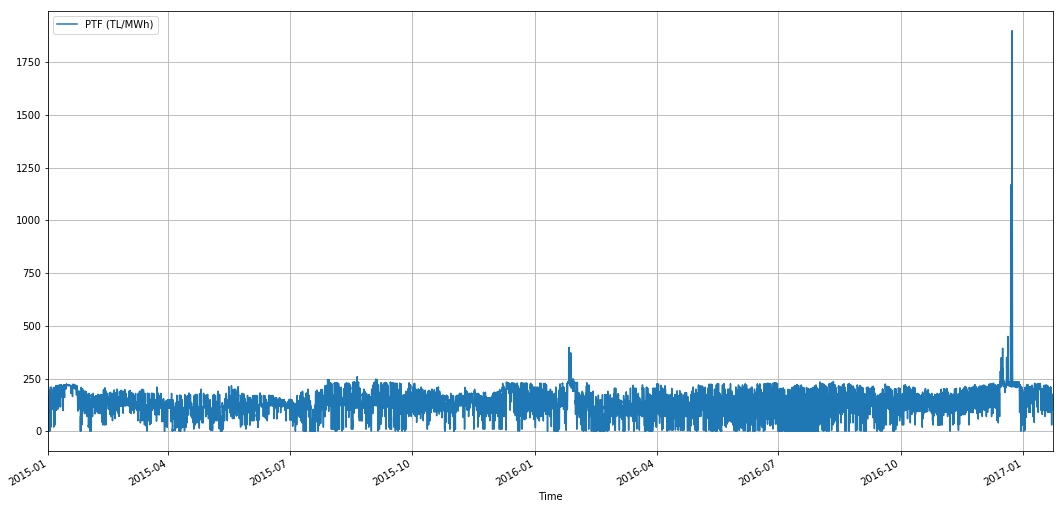

In [0]:
winter_train.plot(grid=True, figsize = (18,9))

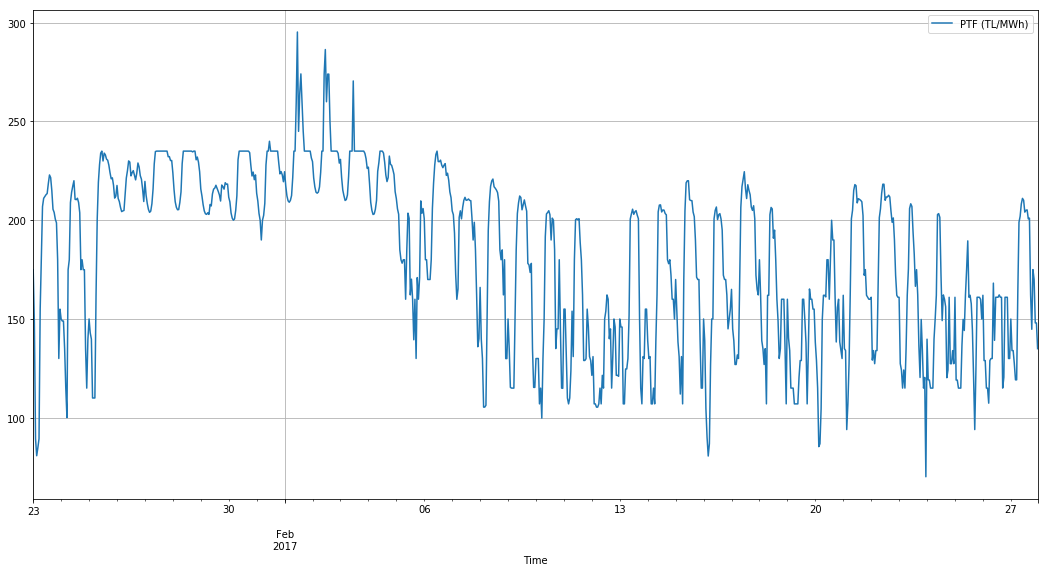

In [0]:
winter_test.plot(grid=True, figsize = (18,9))

In [0]:
#MinMaxScalar is used to normalize the value before training
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(winter_train)
data

In [0]:
winter_train.shape

(18072, 1)